In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd


sys.path.insert(0, "..") 
from src.data import make_dataset
from src.features import build_features
from src.visualization import visualize

pd.set_option("display.precision", 5)
pd.set_option("display.max.columns", None)
pd.options.display.float_format = '{:6.5f}'.format


import seaborn as sns

Bonds

In dit onderzoek is uitgegaan van een beperkte set bonds. Het is nog onduidelijk of de data van verlopen bonds ook zinvol is voor het onderzoek. Een bond is typisch maar kort in portefeuille waardoor we geen lange tijdreeksen hebben van een bepaalde bond. Mogelijk komt de bond wel erg over een met andere bonds die we in het verleden hebben gehad en zegt het koerstverloop van die bonds iets over het koersverloop van de huidige bonds. Mogelijk spelen benchmark bonds hier een rol bij. 

In [2]:
df_bonds = make_dataset.read_pkl('bonds')


2021-12-30 16:33:20.305 | INFO     | src.data.make_dataset:read_pkl:284 - Load preprocessed bonds data


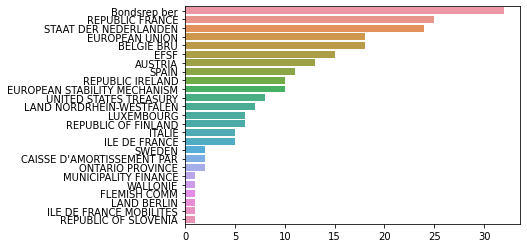

In [15]:
visualize.countplot(data = df_bonds, x = 'issuer_name')

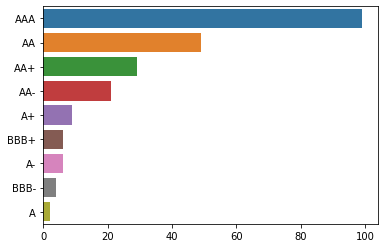

In [16]:
visualize.countplot(data = df_bonds, x = 'issue_rating')

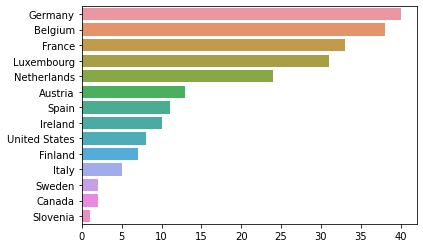

In [17]:
visualize.countplot(data = df_bonds, x = 'country_name')

Bond prices

In [3]:
df_price = make_dataset.read_pkl('price')

2021-12-30 16:33:25.346 | INFO     | src.data.make_dataset:read_pkl:284 - Load preprocessed price data


In [4]:
df_price.columns

Index(['reference_identifier', 'ccy', 'rate_dt', 'mid'], dtype='object')

In [5]:
df_bonds

,ccy,country_name,issue_dt,first_coupon_date,mature_dt,isin,issuer_name,coupon_frq,coupon,tot_issue,cfi_code,issue_rating,bond_duration
0,EUR,Netherlands,2009-02-13,2009-07-15,2019-07-15,NL0009086115,STAAT DER NEDERLANDEN,ANNUAL,4.00000,5000000000.00000,DBFTFN,AAA,3652 days
1,NLG,Austria,1994-02-28,1995-02-28,2024-02-28,NL0000133924,AUSTRIA,ANNUAL,6.25000,1000000000.00000,DBFTXB,AA+,10592 days
2,EUR,Netherlands,2012-03-09,2013-01-15,2033-01-15,NL0010071189,STAAT DER NEDERLANDEN,ANNUAL,2.50000,4160000000.00000,DBFXXN,AAA,7305 days
3,USD,United States,2009-05-15,2009-11-15,2019-05-15,US912828KQ20,UNITED STATES TREASURY,SEMI ANNUAL,3.12500,64411000000.00000,DXXXXX,AAA,3468 days
4,USD,United States,2010-02-15,2010-08-15,2020-02-15,US912828MP29,UNITED STATES TREASURY,SEMI ANNUAL,3.62500,0.00000,DXXXXX,AAA,3471 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,EUR,Spain,2021-06-29,2021-10-31,2031-10-31,ES0000012I32,SPAIN,ANNUAL,0.50000,8000000000.00000,DBFTFB,A-,3652 days
221,EUR,Slovenia,2021-07-01,2021-07-01,2031-07-01,SI0002104196,REPUBLIC OF SLOVENIA,ANNUAL,0.12500,1000000000.00000,DBFTFR,A,3652 days
222,EUR,Belgium,2021-07-06,2021-07-06,2026-07-06,EU000A3KTGV8,EUROPEAN UNION,ANNUAL,0.00000,9000000000.00000,DNFCFB,AAA,1826 days
223,EUR,Belgium,2021-07-06,2021-07-06,2051-07-06,EU000A3KTGW6,EUROPEAN UNION,ANNUAL,0.70000,6000000000.00000,DNFCFB,AAA,10957 days


In [6]:
df = make_dataset.join_bond_data(df_bonds,df_price,['DE0001102309','DE0001102374', 'DE0001135499']) # Example 3 German Bonds 10 Years

<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

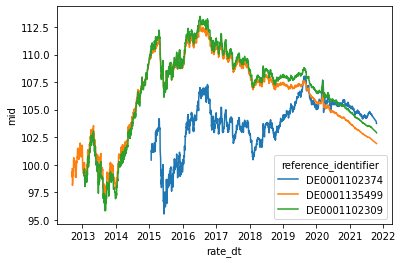

In [7]:
sns.lineplot(data = df, x = 'rate_dt', y = 'mid', hue = 'reference_identifier')

In [57]:
df.head()

,reference_identifier,ccy,rate_dt,mid,country_name,issue_dt,first_coupon_date,mature_dt,isin,issuer_name,coupon_frq,coupon,tot_issue,cfi_code,issue_rating,bond_duration
0,DE0001102374,EUR,2015-01-22,100.42600,Germany,2015-01-16,2016-02-15,2025-02-15,DE0001102374,Bondsrep ber,ANNUAL,0.50000,5000000000.00000,DBFTFB,AAA,3288 days
1,DE0001102374,EUR,2015-01-23,101.32100,Germany,2015-01-16,2016-02-15,2025-02-15,DE0001102374,Bondsrep ber,ANNUAL,0.50000,5000000000.00000,DBFTFB,AAA,3288 days
2,DE0001102374,EUR,2015-01-26,101.20300,Germany,2015-01-16,2016-02-15,2025-02-15,DE0001102374,Bondsrep ber,ANNUAL,0.50000,5000000000.00000,DBFTFB,AAA,3288 days
3,DE0001102374,EUR,2015-01-27,101.10800,Germany,2015-01-16,2016-02-15,2025-02-15,DE0001102374,Bondsrep ber,ANNUAL,0.50000,5000000000.00000,DBFTFB,AAA,3288 days
4,DE0001102374,EUR,2015-01-28,101.30600,Germany,2015-01-16,2016-02-15,2025-02-15,DE0001102374,Bondsrep ber,ANNUAL,0.50000,5000000000.00000,DBFTFB,AAA,3288 days


In [10]:
from src.features import build_features
df = build_features.add_duration(df)




In [11]:
df

,reference_identifier,ccy,rate_dt,mid,country_name,issue_dt,first_coupon_date,mature_dt,isin,issuer_name,coupon_frq,coupon,tot_issue,cfi_code,issue_rating,bond_duration,remain_duration
0,DE0001102374,EUR,2015-01-22,100.42600,Germany,2015-01-16,2016-02-15,2025-02-15,DE0001102374,Bondsrep ber,ANNUAL,0.50000,5000000000.00000,DBFTFB,AAA,3288 days,3677 days
1,DE0001102374,EUR,2015-01-23,101.32100,Germany,2015-01-16,2016-02-15,2025-02-15,DE0001102374,Bondsrep ber,ANNUAL,0.50000,5000000000.00000,DBFTFB,AAA,3288 days,3676 days
2,DE0001102374,EUR,2015-01-26,101.20300,Germany,2015-01-16,2016-02-15,2025-02-15,DE0001102374,Bondsrep ber,ANNUAL,0.50000,5000000000.00000,DBFTFB,AAA,3288 days,3673 days
3,DE0001102374,EUR,2015-01-27,101.10800,Germany,2015-01-16,2016-02-15,2025-02-15,DE0001102374,Bondsrep ber,ANNUAL,0.50000,5000000000.00000,DBFTFB,AAA,3288 days,3672 days
4,DE0001102374,EUR,2015-01-28,101.30600,Germany,2015-01-16,2016-02-15,2025-02-15,DE0001102374,Bondsrep ber,ANNUAL,0.50000,5000000000.00000,DBFTFB,AAA,3288 days,3671 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6178,DE0001102309,EUR,2021-08-31,103.31500,Germany,2013-01-18,2014-02-15,2023-02-15,DE0001102309,Bondsrep ber,ANNUAL,1.50000,5000000000.00000,DBFTFB,AAA,3287 days,533 days
6179,DE0001102309,EUR,2021-09-02,103.29100,Germany,2013-01-18,2014-02-15,2023-02-15,DE0001102309,Bondsrep ber,ANNUAL,1.50000,5000000000.00000,DBFTFB,AAA,3287 days,531 days
6180,DE0001102309,EUR,2021-10-14,102.96600,Germany,2013-01-18,2014-02-15,2023-02-15,DE0001102309,Bondsrep ber,ANNUAL,1.50000,5000000000.00000,DBFTFB,AAA,3287 days,489 days
6181,DE0001102309,EUR,2021-10-15,102.95300,Germany,2013-01-18,2014-02-15,2023-02-15,DE0001102309,Bondsrep ber,ANNUAL,1.50000,5000000000.00000,DBFTFB,AAA,3287 days,488 days


Government Yield

In [23]:
df_yield = make_dataset.read_pkl('yield')

2021-12-30 14:58:00.204 | INFO     | src.data.make_dataset:read_pkl:281 - Load preprocessed yield data


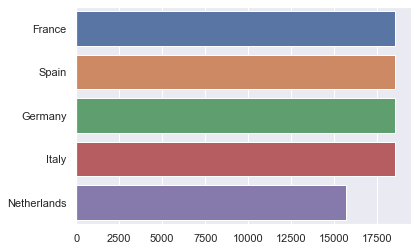

In [24]:
visualize.countplot(data = df_yield, x = 'country')

Credit Spread

Term Spread

Inflation

In [25]:
df_inflation = make_dataset.read_pkl('inflation')

2021-12-30 14:58:06.148 | INFO     | src.data.make_dataset:read_pkl:281 - Load preprocessed inflation data


Inflation should be negatively correlated to the bond price